In [1]:
import glia, tables, numpy as np, torch
import torch.nn.functional as F, torchvision
from glia.reconstructions.lib import ImageData, RetinaData, ImageRetina
import matplotlib.pyplot as plt

In [5]:
data_path = "/mnt/fs1/tbenst/200623_faces/R1_E3_AMES_200min_200f_14l_rgb.h5"
# best VAE
model_base = "/mnt/fs1/tbenst/models/3brain/"

In [3]:
hdf5 = tables.open_file(data_path,'r')
h5 = hdf5.root

# crop image
imgs = h5["images"][0:100]
avg_img = np.mean(imgs, axis=(0,3))
y,x = np.where(avg_img>5)
xleft = min(x)
xright = max(x)
ytop = min(y)
ybot = max(y)

image_dset = ImageData(h5["images"], crop=[ytop,ybot,xleft,xright])
retina_dset = RetinaData(h5["data"], no_units=False)
(image_dset[0].shape, retina_dset[0].shape)

nSamples = len(retina_dset)
train_idx = [i for i in range(nSamples) if (i+1)%5 != 0]
val_idx = np.arange(nSamples)[slice(4,nSamples,10)]
test_idx = np.arange(nSamples)[slice(9,nSamples,10)]
dm = ImageRetina(image_dset, retina_dset,batch_size=64,
                 tvt_idxs=(train_idx, val_idx, test_idx))

# VAE

In [15]:
model_path = model_base+"2020-09-14T04:52:26.169046-optuna/_ckpt_epoch_24.ckpt"

In [14]:
!ls /mnt/fs1/tbenst/models/3brain/2020-09-14T04:52:26.169046-optuna/

_ckpt_epoch_24.ckpt  _ckpt_epoch_3.ckpt      _ckpt_epoch_49_v1.ckpt
_ckpt_epoch_25.ckpt  _ckpt_epoch_49.ckpt     _ckpt_epoch_4.ckpt
_ckpt_epoch_29.ckpt  _ckpt_epoch_49_v0.ckpt


In [16]:
device = 'cuda:8'

In [17]:
from glia.reconstructions.models.vae import VAE
model = VAE.load_from_checkpoint(model_path)

In [18]:
model = model.to(device)

38.292313


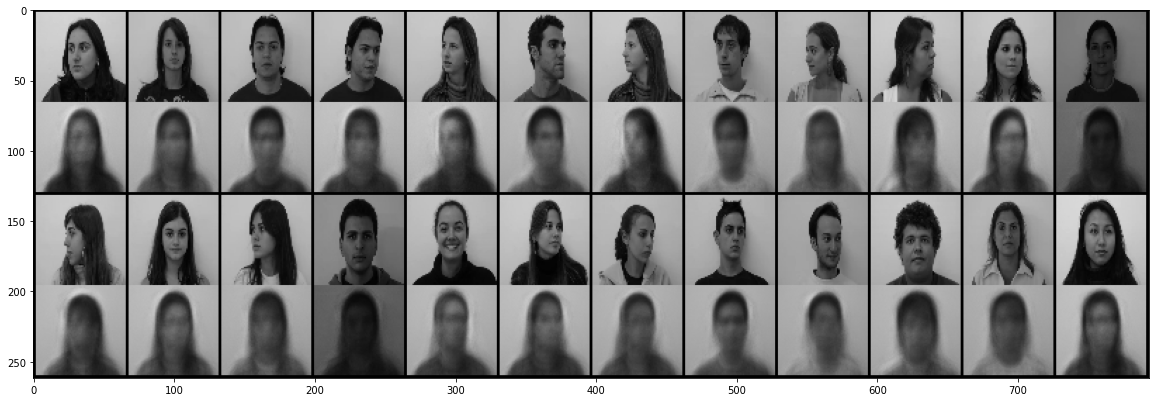

In [19]:
mses = []
with torch.no_grad():
    for batch in dm.val_dataloader():
        bz = batch[0].shape[0]
        images = batch[0].reshape(bz, -1)
        retina = batch[1].reshape(bz, -1) # flatten
        images_pred, mu, logvar = model(retina)
        mse = F.mse_loss(images.to(device), images_pred, reduction="sum")/bz
        mses.append(mse.cpu().numpy())
print(np.array(mses).mean(0))

comparison = torch.cat([images.view(-1,1,model.H,model.W),
               images_pred.view(-1,1,model.H,model.W).cpu()],axis=2).detach()
comparison = torchvision.utils.make_grid(comparison, nrow=12).numpy()
comparison = np.moveaxis(comparison,0,-1)
plt.figure(figsize=(20,20))
plt.imshow(comparison)

In [20]:
latent = model.latents.view(-1,model.n_latent).to(retina.device)
latent_space = model.decode(latent)
ls = latent_space.view(-1, 1, model.H, model.W)
torchvision.utils.save_image(ls,
           model.save_dir+'/sample_' + str(epoch) + '.png',nrow=model.nrow)

ModuleAttributeError: 'VAE' object has no attribute 'latents'

# Conv

In [107]:
ls /mnt/fs1/tbenst/models/3brain/2020-09-14T18:21:53.597586-optuna/trial_126

conv-eigsum_epoch=21_val_mse_loss=47.57.ckpt


In [4]:
# best conv
model_path = model_base+"2020-09-14T18:21:53.597586-optuna/trial_126/conv-eigsum_epoch=21_val_mse_loss=47.57.ckpt"

In [5]:
from glia.reconstructions.models.conv_eigsum import ConvDecoder
model = ConvDecoder.load_from_checkpoint(model_path)
device = 'cuda:9'
model = model.to(device)

mse=tensor(40.7243, device='cuda:9', grad_fn=<DivBackward0>)


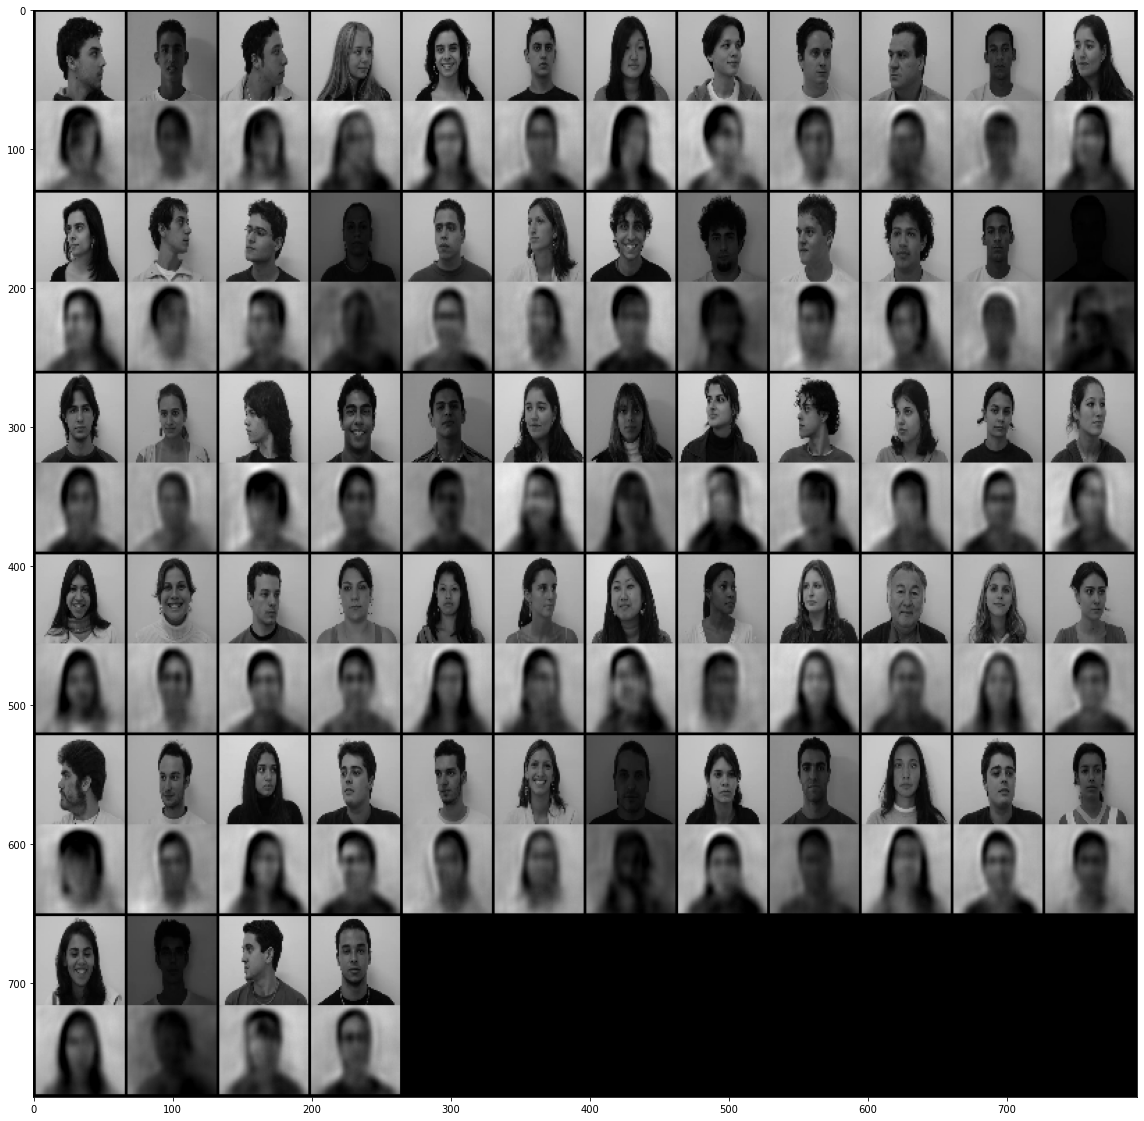

In [9]:
# for batch in dm.train_dataloader():
for batch in dm.val_dataloader():
    bz = batch[0].shape[0]
    images, retina = batch
    images_pred = model(retina.to(device))
    mse = F.mse_loss(images.to(device), images_pred, reduction="sum")/bz
    print(f"{mse=}")
    break

comparison = torch.cat([images.view(-1,1,model.H,model.W),
               images_pred.view(-1,1,model.H,model.W).cpu()],axis=2).detach()
comparison = torchvision.utils.make_grid(comparison, nrow=12).numpy()
comparison = np.moveaxis(comparison,0,-1)
plt.figure(figsize=(20,20))
plt.imshow(comparison)

# John Conv

In [4]:
ls /mnt/fs1/tbenst/models/3brain/2020-09-16T05:06:51.073688-optuna/

trial_103/  trial_26/  trial_37/  trial_60/  trial_76/  trial_89/
trial_111/  trial_31/  trial_53/  trial_69/  trial_82/  trial_97/


In [3]:
ls /mnt/fs1/tbenst/models/3brain/2020-09-16T05:06:51.073688-optuna/trial_103/VAE_epoch\=81_val_mse_loss\=36.62.ckpt

VAE_epoch=81_val_mse_loss=36.62.ckpt


In [6]:
ls /mnt/fs1/tbenst/models/3brain/2020-09-16T05:06:51.073688-optuna/trial_26

VAE_epoch=81_val_mse_loss=49.62.ckpt


In [6]:
# best conv
model_path = model_base+"2020-09-16T05:06:51.073688-optuna/trial_103/VAE_epoch=81_val_mse_loss=36.62.ckpt"

In [7]:
from glia.reconstructions.models.john_conv import ConvNet
model = ConvNet.load_from_checkpoint(model_path)
device = 'cuda:9'
model = model.to(device)

In [11]:
images_pred.shape

torch.Size([64, 64, 64])

In [14]:
images.shape

torch.Size([64, 1, 64, 64])

In [17]:
images.shape

torch.Size([64, 1, 64, 64])

In [29]:
images.cpu().double().dtype

torch.float64

In [33]:
F.mse_loss(images.cpu().double(), images_pred.cpu().double(), reduction="sum")/bz

tensor(13555.9675, dtype=torch.float64)

In [36]:
torch.jit.script(model)

RuntimeError: 
Python type cannot be used as a value:
  File "/home/tbenst/glia/glia/reconstructions/models/john_conv.py", line 66
    def __init__(self, filters):
        super(Block, self).__init__()
              ~~~~~ <--- HERE
        
        self.block = torch.nn.Sequential(


mse=tensor(13612.3730, device='cuda:9')


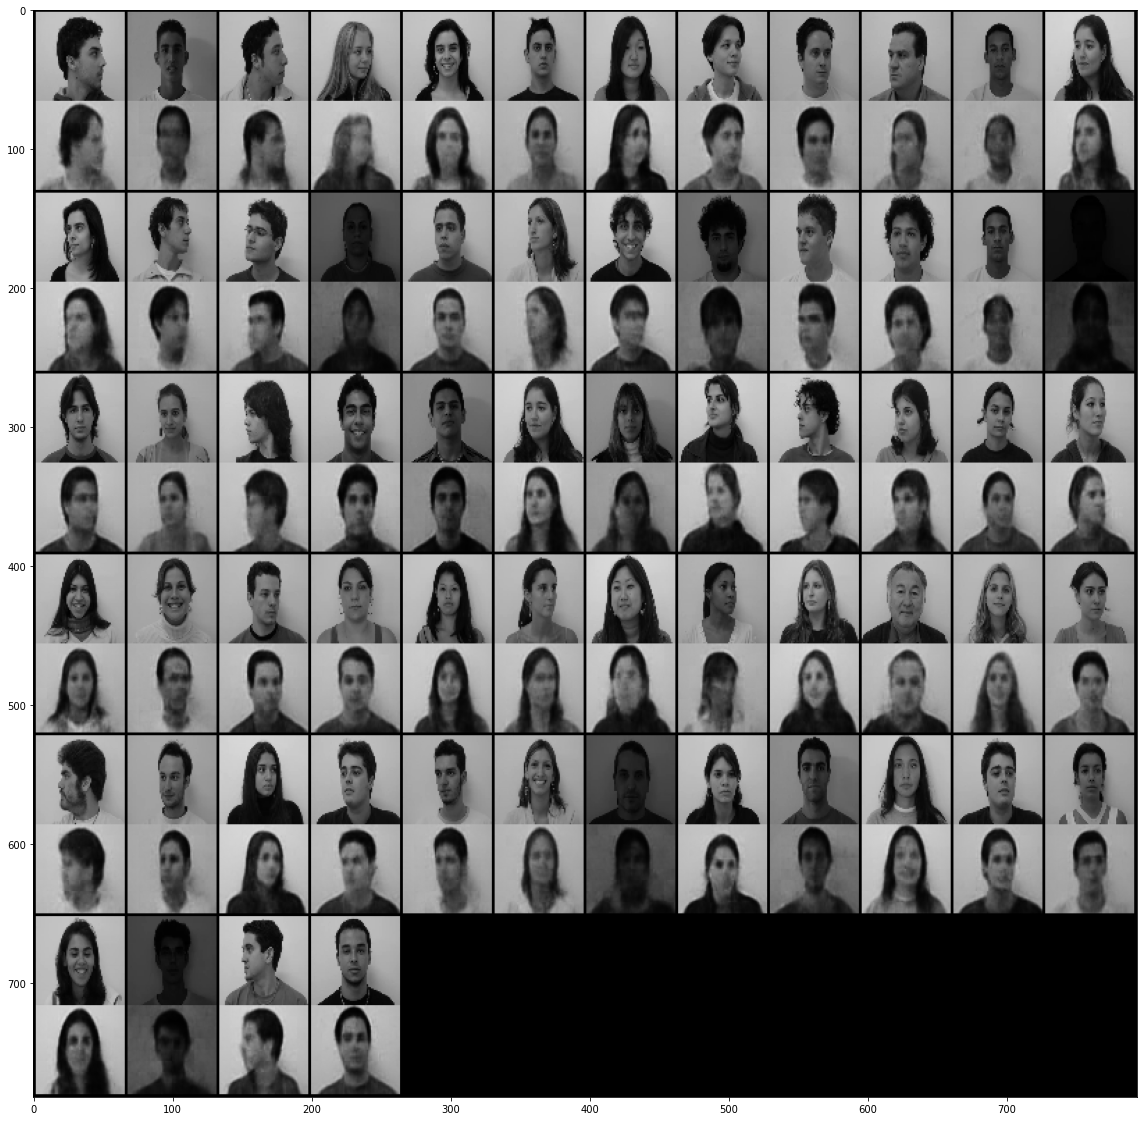

In [35]:
# for batch in dm.train_dataloader():
with torch.no_grad():
    for batch in dm.val_dataloader():
        bz = batch[0].shape[0]
        images, retina = batch
        images_pred = model(retina.to(device))
        mse = F.mse_loss(images.to(device), images_pred, reduction="sum")/bz
        print(f"{mse=}")
        break

comparison = torch.cat([images.view(-1,1,64,64),
               images_pred.view(-1,1,64,64).cpu()],axis=2).detach()
comparison = torchvision.utils.make_grid(comparison, nrow=12).numpy()
comparison = np.moveaxis(comparison,0,-1)
plt.figure(figsize=(20,20))
plt.imshow(comparison)